# Image Captioning
In this notebook, I will use conditioned LSTM for image captioning. The input is an image, and the output is a sequence of words denoting the caption.

## Import the packages

In [1]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from tensorflow.keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

## Load the data
I will use the flickr8k data set, which can be found here: https://forms.illinois.edu/sec/1713398. The image dataset contains about 8000 images and these images are splitted into training, development, test with a ratio of 6:1:1. The tokens dataset contains captions of the images for training.

In [2]:
FLICKR_PATH="data" # The data are stored in a subdirectory called data.
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]
train_list = load_image_list(os.path.join(FLICKR_PATH, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.devImages.txt'))
test_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.testImages.txt'))

In [3]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each item is an image filename.

In [4]:
dev_list[100]

'2736508369_fd9ff0b42f.jpg'

In [5]:
IMG_PATH = os.path.join(FLICKR_PATH, "Flickr8k_Dataset")

## Visualize the image

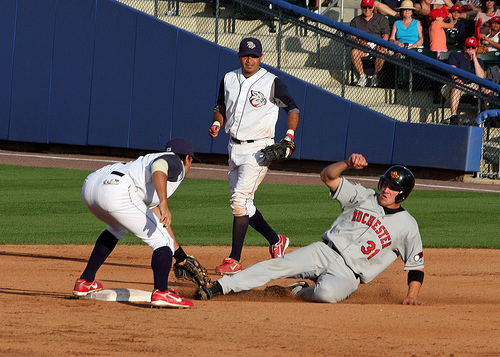

In [6]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[100]))
image

## Encode the image
I will use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model uses a convolution neural network (CNN) for object detection. Here is more detail about this model: 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model input should be images with 299x299 pixels, 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0, so the images have to be normalized before being fed into the model.

In [7]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

Now, let's load the pre-trained Inception model. 

In [8]:
img_model = InceptionV3(weights='imagenet')
img_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

The output for this model is a softmax-activated vector representing 1000 possible object types. However, for the image captioning model, we only need to focus on the encoded representation of the image. I will use the second-to-last layer as the source of image encodings. Each image will be encoded as a vector of size 2048.

In [9]:
new_input = img_model.input
new_output = img_model.layers[-2].output # Skip the last layer
img_encoder = Model(new_input, new_output) # Final encoder model

Now, let's encode all images.

In [10]:
def img_generator(img_list):
    for img_name in img_list:
        img = get_image(img_name)
        img = np.expand_dims(img, axis=0)
        yield img

enc_train = img_encoder.predict(img_generator(train_list), steps=len(train_list), verbose=1)
enc_dev = img_encoder.predict(img_generator(dev_list), steps=len(dev_list), verbose=1)
enc_test = img_encoder.predict(img_generator(test_list), steps=len(test_list), verbose=1)

1000/1000 [==============================] - 11s 11ms/step


Let's visualize the encoding vector.

In [11]:
enc_train[16]

array([0.5125506 , 0.78365886, 1.2485634 , ..., 0.3071013 , 0.8180803 ,
       0.36205825], dtype=float32)

Finally, let's save the encoded matrices, so we do not have to run the encoder again. 

In [12]:
OUTPUT_PATH = "output" 
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

np.save(os.path.join(OUTPUT_PATH,"encoded_images_train.npy"), enc_train)
np.save(os.path.join(OUTPUT_PATH,"encoded_images_dev.npy"), enc_dev)
np.save(os.path.join(OUTPUT_PATH,"encoded_images_test.npy"), enc_test)

## Text data preprocessing
In this part, I will load the image captions and generate training data for the generator model. In the data file `Flickr8k.token.txt`, each line corresponds to a pair of image filename and the caption for that image. Each image file has 5 captions, so there is also a caption number from 0 to 4 in each line. The caption dataset have already been tokenized, so I just split them at white spaces. Also, I will add \<START\> and \<END\> tokens for each sentences and \<PAD\> for padding so that each caption has the same number of tokens.

In [13]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)    
    
    with open(filename) as f:
        lines = f.read().splitlines()
        for line in lines:
            img_name = line.split("#")[0]
            caption = ["<START>"] + (line.split("\t")[1]).split(" ") + ["<END>"]
            image_descriptions[img_name].append(caption)

    return image_descriptions

descriptions = read_image_descriptions(f"{FLICKR_PATH}/Flickr8k.token.txt")

Let's see the descriptions for the first image in the train set.

In [14]:
print(descriptions[train_list[0]])

[['<START>', 'A', 'black', 'dog', 'is', 'running', 'after', 'a', 'white', 'dog', 'in', 'the', 'snow', '.', '<END>'], ['<START>', 'Black', 'dog', 'chasing', 'brown', 'dog', 'through', 'snow', '<END>'], ['<START>', 'Two', 'dogs', 'chase', 'each', 'other', 'across', 'the', 'snowy', 'ground', '.', '<END>'], ['<START>', 'Two', 'dogs', 'play', 'together', 'in', 'the', 'snow', '.', '<END>'], ['<START>', 'Two', 'dogs', 'running', 'through', 'a', 'low', 'lying', 'body', 'of', 'water', '.', '<END>']]


Next, I will create a lookup table from the training data mapping words to indices, since we numeric representations to train the decoder. There is no need to have \<UNK\> token for unseen words, since the generated text will only contain tokens seen at training time.

In [15]:
tokens = set()
for captions in descriptions.values():
    for sequence in captions:
        for tok in sequence:
            tokens.add(tok)
tokens = list(tokens)
tokens.sort()

# 1-index
id_to_word = dict(enumerate(tokens, 1))
# 0 is the padding token.
id_to_word[0] = "<PAD>"

word_to_id = {val: key for key, val in id_to_word.items()}

Now, let's see the maximum number of tokens in a caption to decide the vector size for each caption.

In [16]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

40

## Conditioned LSTM Model

I will now build the model to condition the next word on both the partial sequence and the encoded image. I will first project the 2048-dimensional image encoding to a 300-dimensional hidden layer, and then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the model looks like: 

In [17]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300
vocab_size = len(word_to_id)

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 300)          614700      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 40, 300)      0           ['dense[0][0]']                  
                                                                                            

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
The output is a (batch_size, vocab_size) ndarray of predicted word distributions.   

In [18]:
enc_train = np.load(f"{OUTPUT_PATH}/encoded_images_train.npy")
enc_dev = np.load(f"{OUTPUT_PATH}/encoded_images_dev.npy")

In [19]:
def training_generator(batch_size=128):
    def get_data(sequence):
        inputs = np.empty((0,MAX_LEN))
        outputs = np.empty((0,vocab_size))
        
        inp = np.zeros(MAX_LEN)
        for index, tok in enumerate(sequence):
            if tok == "<END>":
                break

            inp[index] = word_to_id[tok]
            inputs = np.append(inputs, [inp], axis = 0)
            out = np.zeros(vocab_size)
            out[word_to_id[sequence[index+1]]] = 1
            outputs = np.append(outputs, [out], axis = 0)
        
        return inputs, outputs
    
    count = 0
    batch_input = np.empty((batch_size,MAX_LEN))
    batch_output = np.empty((batch_size,vocab_size))
    batch_img = np.empty((batch_size,2048))
    while True:
        for index, train_file in enumerate(train_list):
            img = enc_train[index]
            for sequence in descriptions[train_file]:
                inputs, outputs = get_data(sequence)
                for i in range(len(inputs)):
                    batch_input[count] = np.array([inputs[i]])
                    batch_output[count] = np.array([outputs[i]])
                    batch_img[count] = np.array([img])
                    count += 1
                    if count == batch_size:
                        count = 0
                        yield [batch_img, batch_input], batch_output

In [20]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [21]:
model.fit(generator, steps_per_epoch=steps, verbose=True, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 31s 14ms/step - loss: 4.4705 - accuracy: 0.2630
Epoch 2/20
1875/1875 [==============================] - 26s 14ms/step - loss: 3.6953 - accuracy: 0.3595
Epoch 3/20
1875/1875 [==============================] - 26s 14ms/step - loss: 3.4907 - accuracy: 0.3807
Epoch 4/20
1875/1875 [==============================] - 26s 14ms/step - loss: 3.3658 - accuracy: 0.3904
Epoch 5/20
1875/1875 [==============================] - 26s 14ms/step - loss: 3.3301 - accuracy: 0.3971
Epoch 6/20
1875/1875 [==============================] - 26s 14ms/step - loss: 3.2435 - accuracy: 0.4032
Epoch 7/20
1875/1875 [==============================] - 26s 14ms/step - loss: 3.2624 - accuracy: 0.4041
Epoch 8/20
1875/1875 [==============================] - 26s 14ms/step - loss: 3.2352 - accuracy: 0.4069
Epoch 9/20
1875/1875 [==============================] - 26s 14ms/step - loss: 3.2493 - accuracy: 0.4099
Epoch 10/20
1875/1875 [==============================] - 26s 14m

The model has accuracy of about 40%.

Save the model.

In [22]:
model.save_weights(f"{OUTPUT_PATH}/model.h5")

Load the model. 

In [23]:
model.load_weights(f"{OUTPUT_PATH}/model.h5")

The decoder model decodes a sequence of tokens starting at \<START\> and predict the next token continuously until hit \<END\> or reaches `MAX_LEN`

In [42]:
def img_decoder(enc_image): 
    tok = "<START>"
    tok_id = word_to_id[tok]
    inp = np.zeros(MAX_LEN)
    inp[0] = tok_id
    length = 1
    result = [tok]
    while tok != "<END>" and length < MAX_LEN:
        prob =  model.predict([np.array([enc_image]), np.array([inp])], verbose = 0)
        tok_id = np.argmax(prob)
        tok = id_to_word[tok_id]
        result.append(tok)
        inp[length] = tok_id
        length += 1
    return result


Here is one example of captions for the training images, which is pretty reasonable.

['<START>',
 'A',
 'dog',
 'and',
 'a',
 'dog',
 'are',
 'in',
 'the',
 'snow',
 '.',
 '<END>']

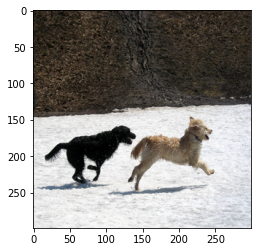

In [43]:
plt.imshow(get_image(train_list[0]))
img_decoder(enc_train[0])

Here is one example of captions for the development images. Although not good as the training image, it still makes much sense.

['<START>',
 'A',
 'man',
 'in',
 'a',
 'blue',
 'shirt',
 'and',
 'a',
 'woman',
 'in',
 'a',
 'white',
 'shirt',
 '.',
 '<END>']

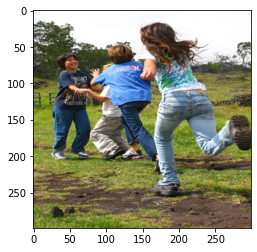

In [49]:
plt.imshow(get_image(dev_list[7]))
img_decoder(enc_dev[7])